In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from matplotlib import rc
warnings.filterwarnings('ignore')

# Unicode warning 제거 (폰트 관련 경고메시지)
plt.rcParams['axes.unicode_minus']=False
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_csv('shopping_trends_updated1.csv')
df.head()

,Unnamed: 0,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,...,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,Item Purchased_new,Age_group,location_new
0,0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,...,Yes,Express,Yes,Yes,14,Venmo,Fortnightly,tops,50s,South
1,1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,...,Yes,Express,Yes,Yes,2,Cash,Fortnightly,tops,10-20s,Northeast
2,2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,...,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly,bottoms,50s,Northeast
3,3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,...,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly,shoes,10-20s,Northeast
4,4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,...,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually,tops,40s,West


## 고객 분류

### 고객 분류 기준
- New Customer : 6개월 이내에 구매한 고객
- InActive Customer : 구매 주기가 1년이면서 구매 횟수가 5회 미만
- Loyal Customer Regular Customer Light Customer은 RFM 점수를 통해 집단 분류

In [3]:
def Previous_Purchases_score(x, df):
    q80 = df['Previous Purchases'].quantile(0.8)
    q60 = df['Previous Purchases'].quantile(0.6)
    q40 = df['Previous Purchases'].quantile(0.4)
    q20 = df['Previous Purchases'].quantile(0.2)
    
    if x >= q80:
        return 5
    elif x >= q60:
        return 4
    elif x >= q40:
        return 3
    elif x >= q20:
        return 2
    else:
        return 1
df['Previous Purchases Score'] = df['Previous Purchases'].apply(lambda x: Previous_Purchases_score(x, df))

In [4]:
def Frequency_Purchases_Score(x):
    if x == 'Weekly':
        return 5
    elif x in ['Bi-Weekly', 'Fortnightly']:
        return 4
    elif x == 'Monthly':
        return 3
    elif x in ['Quarterly', 'Every 3 Months']:
        return 2
    elif x == 'Annually':
        return 1
df['Frequency Purchases Score'] = df['Frequency of Purchases'].apply(lambda x : Frequency_Purchases_Score(x))

In [5]:
df['Total_Amount'] = df['Purchase Amount (USD)'] * (df['Previous Purchases'] + 1)
def Total_Purchases_Amount_Score(x,df):
    q80 = df['Total_Amount'].quantile(0.8)
    q60 = df['Total_Amount'].quantile(0.6)
    q40 = df['Total_Amount'].quantile(0.4)
    q20 = df['Total_Amount'].quantile(0.2)
    if x >= q80:
        return 5
    elif x >= q60:
        return 4
    elif x >= q40:
        return 3
    elif x >= q20:
        return 2
    else:
        return 1
df['Total_Purchases_Amount_Score'] = df['Total_Amount'].apply(lambda x : Total_Purchases_Amount_Score(x,df))

In [6]:
df['Total Score'] = df['Previous Purchases Score'] + df['Frequency Purchases Score'] + df['Total_Purchases_Amount_Score']

Text(0.5, 0, 'RFM Score')

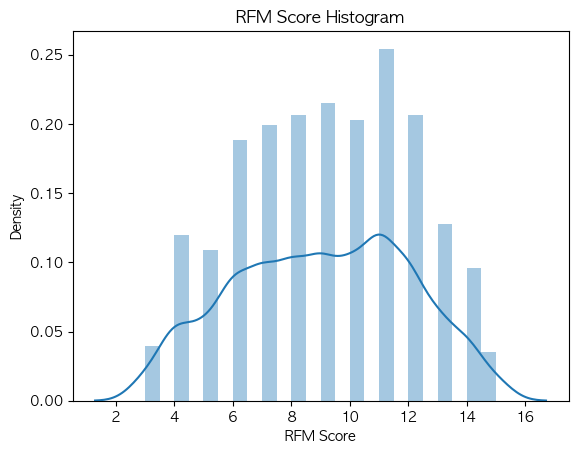

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(df['Total Score'])
plt.title("RFM Score Histogram")
plt.xlabel("RFM Score")

In [8]:
def classify_customer(row):
    if (row['Previous Purchases'] <= 5) and (row['Frequency of Purchases'] in ['Weekly', 'Bi-Weekly','Fortnightly','Monthly']):
        return 'New Customer' # 신규 고객
    elif (row['Previous Purchases'] <= 5) and (row['Frequency of Purchases'] == 'Annually'):
        return 'InActive Customer' # 장기 미접속
    elif row['Total Score'] >= 13:
        return 'Loyal Customer'
    elif row['Total Score'] <= 5:
        return 'Light Customer'
    else:
        return 'Regural Customer'

df['Customer Type'] = df.apply(classify_customer, axis = 1)

In [9]:
df['Customer Type'].value_counts()

Customer Type
Regural Customer     2685
Loyal Customer        505
Light Customer        412
New Customer          244
InActive Customer      54
Name: count, dtype: int64

## 고객 별 CLV(고객 평생 가치) 계산 후 집중 타겟 고객 판별

In [10]:
df = pd.read_csv('shopping_trends_updated_new.csv')
df.head()

,Unnamed: 0,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,...,Frequency of Purchases,Item Purchased_new,Age_group,location_new,Previous Purchases Score,Frequency Purchases Score,Total_Amount,Total_Purchases_Amount_Score,Total Score,Customer Type
0,0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,...,Fortnightly,tops,50s,South,2,4,795,2,8,Regural Customer
1,1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,...,Fortnightly,tops,10-20s,Northeast,1,4,192,1,6,New Customer
2,2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,...,Weekly,bottoms,50s,Northeast,3,5,1752,4,12,Regural Customer
3,3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,...,Weekly,shoes,10-20s,Northeast,5,5,4500,5,15,Loyal Customer
4,4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,...,Annually,tops,40s,West,4,1,1568,3,8,Regural Customer


In [11]:
frequency_mapping = {
    'Weekly': 52, 'Bi-Weekly': 26, 'Fortnightly': 26, 'Monthly': 12,
    'Quarterly': 4, 'Every 3 Months': 4, 'Annually': 1
}
df['Frequency Value'] = df['Frequency of Purchases'].map(frequency_mapping)

apv_grouped = df.groupby('Customer Type')['Purchase Amount (USD)'].mean()

frequency_grouped = df.groupby('Customer Type')['Frequency Value'].mean()

customer_lifespan = 5

clv_calculated = apv_grouped * frequency_grouped * customer_lifespan

clv = clv_calculated.rename('CLV').reset_index()
clv

,Customer Type,CLV
0,InActive Customer,313.981481
1,Light Customer,894.938437
2,Loyal Customer,12284.948809
3,New Customer,8881.384037
4,Regural Customer,4591.348297


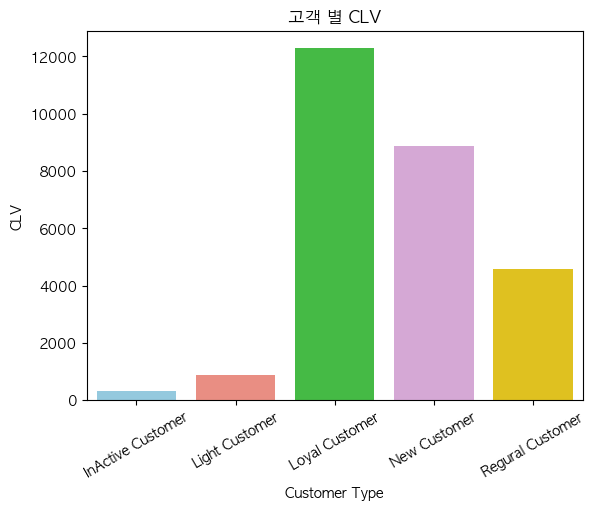

In [12]:
palette_colors = ['skyblue', 'salmon', 'limegreen', 'plum', 'gold']
sns.barplot(x = clv['Customer Type'], y = clv['CLV'],palette = palette_colors)
plt.title("고객 별 CLV")
plt.xticks(rotation = 30)
plt.show()

## 구독 여부에 따른 CLV 계산

In [13]:
apv_grouped = df.groupby(['Customer Type', 'Subscription Status'])['Purchase Amount (USD)'].mean()

frequency_grouped = df.groupby(['Customer Type', 'Subscription Status'])['Frequency Value'].mean()

customer_lifespan = 5

clv_calculated = apv_grouped * frequency_grouped * customer_lifespan

sub_clv = clv_calculated.unstack().reset_index()
sub_clv[sub_clv['Customer Type'].isin(['New Customer', 'Loyal Customer'])]

Subscription Status,Customer Type,No,Yes
2,Loyal Customer,12223.145049,12433.716029
3,New Customer,8799.738912,9143.813481


## 나이대별 세분화

In [15]:
apv_grouped_age = df.groupby(['Age_group', 'Customer Type', 'Subscription Status'])['Purchase Amount (USD)'].mean()

frequency_grouped_age = df.groupby(['Age_group', 'Customer Type', 'Subscription Status'])['Frequency Value'].mean()

clv_calculated_age = apv_grouped_age * frequency_grouped_age * customer_lifespan

clv_result_age = clv_calculated_age.unstack().unstack()

clv_result_age

clv_result_age.reset_index(inplace = True)
clv_result_age

Subscription Status Age_group                No                                \
Customer Type                 InActive Customer Light Customer Loyal Customer   
0                      10-20s        334.500000     944.620458   12308.003809   
1                         30s        328.333333    1077.330178   11061.074219   
2                         40s        239.000000     953.127643   12668.761850   
3                         50s        315.000000     844.470000   12754.656250   
4                        60s+        319.500000     832.693910   12190.620748   

Subscription Status                                             Yes  \
Customer Type       New Customer Regural Customer InActive Customer   
0                    8578.613078      4644.696669        318.333333   
1                    8925.383492      4757.615863        325.000000   
2                    9118.151927      4761.824051        380.000000   
3                    8978.833792      4346.459007        290.000000   
4                    8221.449704      4220.487308        325.000000   

Subscription Status                                              \
Customer Type       Light Customer Loyal Customer  New Customer   
0                       781.200000   11365.556712   9675.867347   
1                       590.104167   12024.201389  10613.950617   
2                       940.608000   11770.434783   9631.530612   
3                       870.034602   13871.911765   8233.724490   
4                       815.273438   12593.722222   6844.444444   

Subscription Status                   
Customer Type       Regural Customer  
0                        4608.125000  
1                        4680.256790  
2                        4371.694698  
3                        5150.063651  
4                        4697.146230

In [16]:
melted_clv = clv_result_age.melt(id_vars=['Age_group'], 
                                       var_name=['Subscription Status', 'Customer Type'], 
                                       value_name='CLV')
melted_clv

,Age_group,Subscription Status,Customer Type,CLV
0,10-20s,No,InActive Customer,334.500000
1,30s,No,InActive Customer,328.333333
2,40s,No,InActive Customer,239.000000
3,50s,No,InActive Customer,315.000000
4,60s+,No,InActive Customer,319.500000
5,10-20s,No,Light Customer,944.620458
6,30s,No,Light Customer,1077.330178
7,40s,No,Light Customer,953.127643
8,50s,No,Light Customer,844.470000
9,60s+,No,Light Customer,832.693910


In [17]:
yes_clv = melted_clv[melted_clv['Subscription Status'] == 'Yes']
no_clv = melted_clv[melted_clv['Subscription Status'] == 'No']

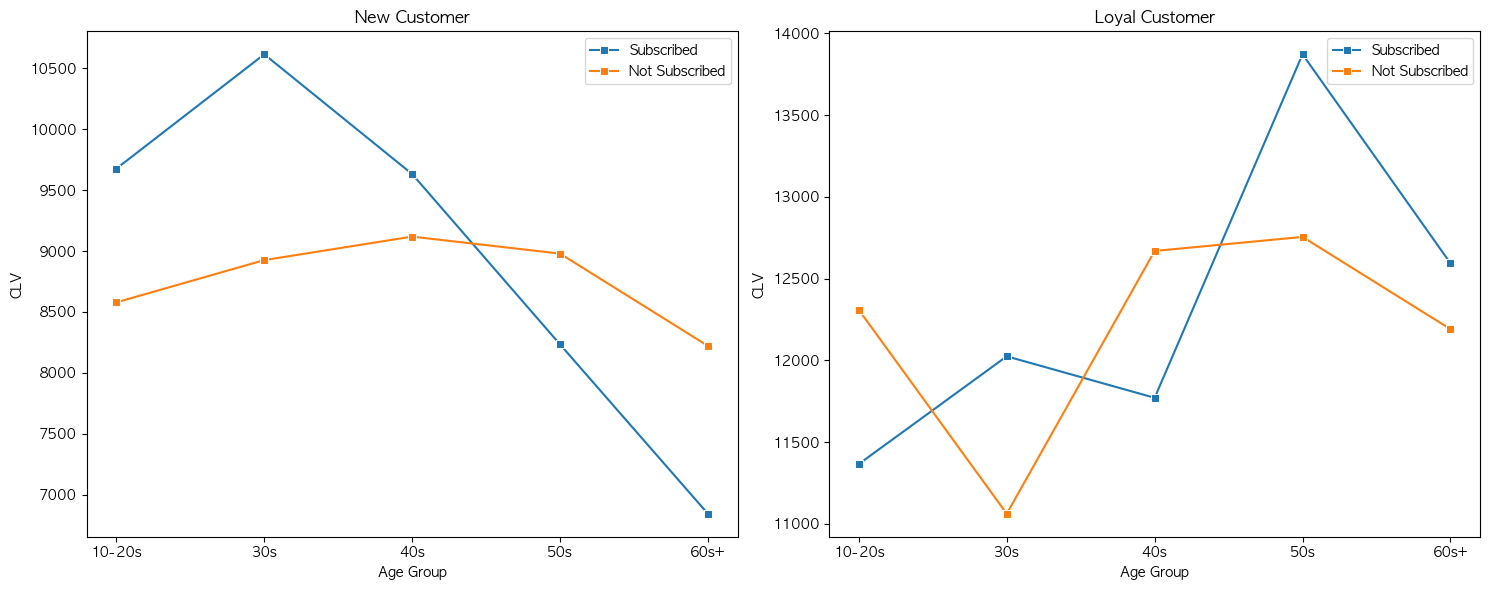

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=True)
customer_types = ['New Customer', 'Loyal Customer']

for ax, customer_type in zip(axes, customer_types):
    sns.lineplot(data=yes_clv[yes_clv['Customer Type'] == customer_type], 
                 x='Age_group', y='CLV', marker='s', label='Subscribed', ax=ax)
    
    sns.lineplot(data=no_clv[no_clv['Customer Type'] == customer_type], 
                 x='Age_group', y='CLV', marker='s', label='Not Subscribed', ax=ax)
    
    ax.set_title(customer_type)
    ax.set_xlabel('Age Group')
    ax.set_ylabel('CLV')
    ax.legend()

plt.tight_layout()
plt.show()

## 구독 여부에 따른 CLV 차이가 유의미한지 검정

In [19]:
df['CLV'] = df['Purchase Amount (USD)'] * df['Frequency Value'] + 5

Text(0.5, 1.0, 'CLV Distribution')

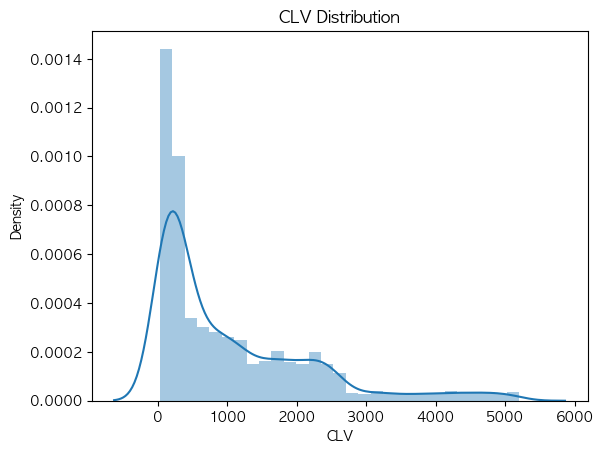

In [20]:
sns.distplot(df['CLV'])
plt.title("CLV Distribution")

Text(0.5, 1.0, 'CLV Log Distribution')

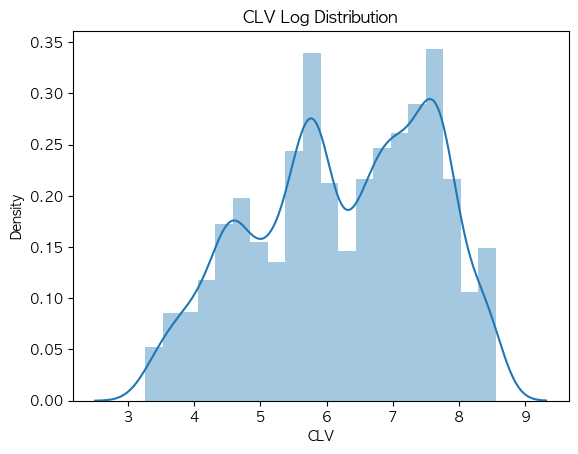

In [21]:
sns.distplot(np.log1p(df['CLV']))
plt.title("CLV Log Distribution")

In [22]:
df['CLV_log'] = np.log1p(df['CLV'])

In [23]:
from scipy.stats import ttest_ind
df_target_customer = df[df['Customer Type'].isin(['Loyal Customer','New Customer'])]
customers = df_target_customer['Customer Type'].unique()
comparison_results = []

for customer in customers:
    data = df_target_customer[df_target_customer['Customer Type'] == customer]
    subscriber_clv = data[data['Subscription Status'] == 'Yes']['CLV_log']
    non_subscriber_clv = data[data['Subscription Status'] == 'No']['CLV_log']
    t_stat, p_value = ttest_ind(subscriber_clv, non_subscriber_clv, equal_var=False)
    comparison_results.append({
            'Group1': customer,
            'Group2': customer,
            'T-statistic': t_stat,
            'P-value': p_value
        })
comparison_results_df = pd.DataFrame(comparison_results)
comparison_results_df

,Group1,Group2,T-statistic,P-value
0,New Customer,New Customer,0.573303,0.567706
1,Loyal Customer,Loyal Customer,0.236177,0.813480


In [24]:
from scipy.stats import ttest_ind
import pandas as pd

age_groups = df_target_customer['Age_group'].unique()
customers = df_target_customer['Customer Type'].unique()
comparison_results = []

for age_group in age_groups:
    for customer in customers:
        data = df_target_customer[(df_target_customer['Age_group'] == age_group) & (df_target_customer['Customer Type'] == customer)]
        subscriber_clv = data[data['Subscription Status'] == 'Yes']['CLV_log']
        non_subscriber_clv = data[data['Subscription Status'] == 'No']['CLV_log']
        
        if len(subscriber_clv) > 0 and len(non_subscriber_clv) > 0:
            t_stat, p_value = ttest_ind(subscriber_clv, non_subscriber_clv, equal_var=False)
            comparison_results.append({
                    'Age_group': age_group,  
                    'Customer_Type': customer,
                    'T-statistic': t_stat,
                    'P-value': p_value
                })

comparison_results_df = pd.DataFrame(comparison_results)
comparison_results_df.sort_values(by = ['Customer_Type','Age_group'])

,Age_group,Customer_Type,T-statistic,P-value
1,10-20s,Loyal Customer,-0.952079,0.346185
5,30s,Loyal Customer,0.637247,0.527400
9,40s,Loyal Customer,-0.549754,0.585306
7,50s,Loyal Customer,1.178002,0.242528
3,60s+,Loyal Customer,0.378396,0.706480
0,10-20s,New Customer,0.383252,0.704628
4,30s,New Customer,0.978247,0.347710
8,40s,New Customer,0.130373,0.897495
6,50s,New Customer,0.139760,0.889630
2,60s+,New Customer,-0.391505,0.707140


## 집단(Royal, New Customer)간 계절별 아이템 구매 품목에 차이가 존재하는가? 검정 => 카이제곱 검정

### New Customer VS Loyal Customer

In [26]:
from scipy.stats import chi2_contingency

filtered_df = df[df['Customer Type'].isin(['New Customer', 'Loyal Customer'])]

chi2_results = []

for season in filtered_df['Season'].unique():
    season_data = filtered_df[filtered_df['Season'] == season]
    
    contingency_table = pd.crosstab(season_data['Customer Type'], season_data['Item Purchased_new'])
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    chi2_results.append({
        'Season': season,
        'Chi2': chi2,
        'P-value': p,
        'Degrees of Freedom': dof
    })

chi2_results_df = pd.DataFrame(chi2_results)
chi2_results_df

,Season,Chi2,P-value,Degrees of Freedom
0,Winter,1.507642,0.958985,6
1,Spring,4.768835,0.573785,6
2,Summer,12.618973,0.049502,6
3,Fall,5.298435,0.506145,6


## 집단 간 평점 차이 검정

In [29]:
from scipy.stats import ttest_ind
group1 = df[df['Customer Type'] == 'New Customer']['Review Rating']
group2 = df[df['Customer Type'] == 'Loyal Customer']['Review Rating']
group3 = df['Review Rating']

t_stat, p_value = ttest_ind(group1, group2)
lis = [{'T-statistic' : t_stat, 'p-value' : p_value}]
con = pd.DataFrame(lis)
con

,T-statistic,p-value
0,-1.515948,0.129956


## 여름 중 집단 간 지역별 아이탬 구매 빈도 차이 검정

In [31]:
df_summer = df[df['Season'] == 'Summer']
filtered_df = df_summer[df_summer['Customer Type'].isin(['New Customer', 'Loyal Customer'])]

chi2_results = []

for location in filtered_df['location_new'].unique():
    location_data = filtered_df[filtered_df['location_new'] == location]
    
    contingency_table = pd.crosstab(location_data['Customer Type'], location_data['Item Purchased_new'])
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    chi2_results.append({
        'Location': location,
        'Chi2': chi2,
        'P-value': p,
        'Degrees of Freedom': dof
    })

chi2_results_df = pd.DataFrame(chi2_results)
chi2_results_df

,Location,Chi2,P-value,Degrees of Freedom
0,Northeast,6.476190,0.372010,6
1,South,9.133203,0.166224,6
2,West,5.841944,0.441127,6
3,Midwest,2.624898,0.757579,5
